# QCoDeS Example with DynaCool PPMS

This notebook explains how to control the DynaCool PPMS from QCoDeS.

For this setup to work, the proprietary `PPMS Dynacool` application (or, alternatively `Simulate PPMS Dynacool`) must be running on some PC. On that same PC, the `server.py` script (found in `qcodes/instrument_drivers/QuantumDesign/DynaCoolPPMS/private`) must be running. The script can be run from the command line with no arguments and will run under python 3.6+.

The architecture is as follows:

The QCoDeS driver sends strings via VISA to the server who passes those same strings on to the `CommandHandler` (found in `qcodes/instrument_drivers/QuantumDesign/DynaCoolPPMS/commandhandler`). The `CommandHandler` makes the calls into the proprietary API. The QCoDeS driver can thus be called on any machine that can communicate with the machine hosting the server.

Apart from that, the driver is really simple. For this notebook, we used the `Simulate PPMS Dynacool` application running on the same machine as QCoDeS.

In [1]:
%matplotlib notebook
from qcodes.instrument_drivers.QuantumDesign.DynaCoolPPMS.DynaCool import DynaCool

To instantiate the driver, simply provide the address and port in the standard VISA format.
The connect message is not too pretty, but there does not seem to be a way to query serial and firmware versions.

In [2]:
dynacool = DynaCool('dynacool', address="TCPIP0::127.0.0.1::5000::SOCKET")

Connected to:  QuantumDesign dynacool (serial:N/A, firmware:N/A) in 0.08s


To get an overview over all available parameters, use `print_readable_snapshot`.

A value of "Not available" means (for this driver) that the parameter has been deprecated.

In [4]:
dynacool.print_readable_snapshot(update=True)

dynacool:
	parameter           value
--------------------------------------------------------------------------------
IDN                  :	{'vendor': ' QuantumDesign', 'model': 'dynacool', 'ser...
chamber_state        :	sealed 
chamber_temperature  :	294.6 (K)
field                :	Not available (T)
field_approach       :	linear 
field_measured       :	0 (T)
field_rate           :	0.5 (T/s)
field_setpoint       :	Not available (T)
field_target         :	0 (T)
magnet_state         :	holding 
temperature          :	294.6 (K)
temperature_rate     :	0 (K/s)
temperature_setpoint :	294.6 (K)
temperature_settling :	fast settle 
temperature_state    :	stable 
timeout              :	5 (s)


## Temperature Control

As soon as ANY of the temperature rate, the temperature setpoint, or the temperature settling mode parameters has been set, the system will start moving to the given temperature setpoint at the given rate using the given settling mode.

The system can continuously be queried for its temperature.

In [5]:
from time import sleep
import matplotlib.pyplot as plt
import numpy as np

# example 1

dynacool.temperature_rate(0.1)
dynacool.temperature_setpoint(dynacool.temperature() - 1.3)

temps = []

while dynacool.temperature_state() == 'tracking':
    temp = dynacool.temperature()
    temps.append(temp)
    sleep(0.75)
    print(f'Temperature is now {temp} K')



Temperature is now 294.5997619628906 K
Temperature is now 294.499755859375 K
Temperature is now 294.3997497558594 K
Temperature is now 294.29974365234375 K
Temperature is now 294.29974365234375 K
Temperature is now 294.1997375488281 K
Temperature is now 294.0997314453125 K
Temperature is now 293.9997253417969 K
Temperature is now 293.89971923828125 K
Temperature is now 293.89971923828125 K


<IPython.core.display.Javascript object>


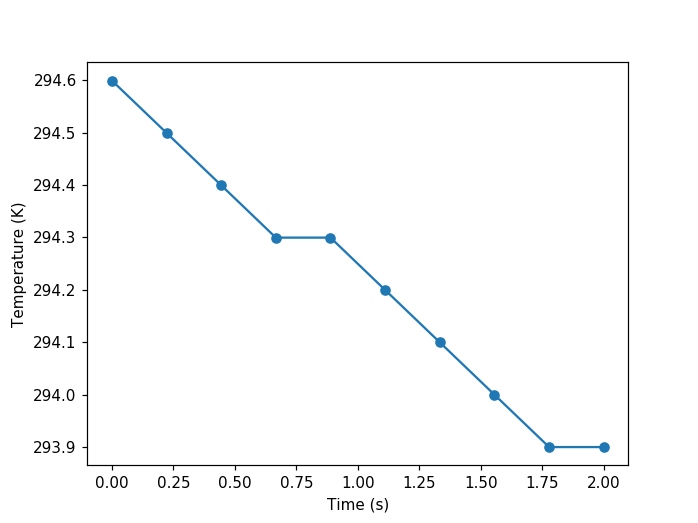

Text(0, 0.5, 'Temperature (K)')

In [6]:
plt.figure()
timeax = np.linspace(0, len(temps)*0.2, len(temps))
plt.plot(timeax, temps, '-o')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

## Field Control

The field has **four** related parameters:

- `field_measured`: (read-only) the field strength right now
- `field_target`: the target field that the `ramp` method will ramp to when called. Setting this parameter does **not** trigger a ramp
- `field_rate`: the field ramp rate. NB: setting this parameter **will** trigger a ramp
- `field_approach`: the approach the system should use to ramp. NB: setting this parameter **will** trigger a ramp

The idea is that the user first sets the `field_target` and then ramps the field to that target using the `ramp` method. The ramp method takes a `mode` argument that controls whether the ramp is blocking or non-blocking. 

Using the simulation software, the field change is instanteneous irrespective of rate. We nevertheless include two examples of ramping here.

### A blocking ramp

First, we set a field target:

In [7]:
field_now = dynacool.field_measured()
target = field_now + 1
dynacool.field_target(target)

Note that the field has not changed yet:

In [8]:
assert dynacool.field_measured() == field_now

And now we ramp:

In [9]:
dynacool.ramp(mode='blocking')

The ramping will take some finite time on a real instrument. The field value is now at the target field:

In [10]:
print(f'Field value: {dynacool.field_measured()} T')
print(f'Field target: {dynacool.field_target()} T')

Field value: 1.0 T
Field target: 1.0 T


### A non-blocking ramp

The non-blocking ramp is very similar to the the blocking ramp.

In [11]:
field_now = dynacool.field_measured()
target = field_now - 0.5
dynacool.field_target(target)

assert dynacool.field_measured() == field_now

dynacool.ramp(mode='non-blocking')
# Here you can do stuff while the magnet ramps

print(f'Field value: {dynacool.field_measured()} T')
print(f'Field target: {dynacool.field_target()} T')

Field value: 0.5 T
Field target: 0.5 T
